# Sentiment Analysis with Transformer Networks

## SA with pretrained huggingface models

In [1]:
!nvidia-smi

Mon Jun 20 08:19:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    13W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# install transformer library
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 10.1 MB/s 
     |████████████████████████████████| 6.6 MB 17.4 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 596 kB 42.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Create a global variable to indicate whether the notebook is run in Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

# Configure variables pointing to directories and stored files 
if IN_COLAB:
    # Mount Google-Drive
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_DIR = '/content/drive/My Drive/data/'  # adjust to Google drive folder with the data if applicable
else:
    DATA_DIR = './' # adjust to the directory where data is stored on your machine (if running the notebook locally)

sys.path.append(DATA_DIR)

CLEAN_REVIEW = DATA_DIR + 'imdb_clean_full_v2.pkl'   # List with tokenized reviews after standard NLP preparation

Mounted at /content/drive


In [5]:
import pickle
with open(CLEAN_REVIEW,'rb') as path_name:
    df = pickle.load(path_name)

In [6]:
# Binary-encode the target variable
df['sentiment'] = df['sentiment'].map({'positive' : 1, 'negative': 0})

In [7]:
# Draw a random sample of n reviews to increase the speed of the following steps
n = 5000
np.random.seed(111)
ix = np.random.randint(0, high=df.shape[0]-1, size=n)
df = df.loc[ix, :]
df.reset_index(drop=True, inplace=True)
df.head()

,review,sentiment,review_clean
0,Started watching this but didn't believe in an...,0,start watch believe character particular relat...
1,This totally UNfunny movie is so over the top ...,0,totally unfunny movie top pathetic unrealistic...
2,There is absolutely nothing to redeem this mov...,0,absolutely nothing redeem movie take sleazy st...
3,*****Warning: May contain SPOILERS********* My...,0,warn may contain spoiler huge problem movie to...
4,It's not surprising that the majority of highe...,1,surprising majority high rat vote submit femal...


Because the transformer network is capable on picking up on more complex patterns, the preprocessing we did is actually accompanied by a loss of information. We will therefore be using the raw unpreprocessed review texts for finetuning the transformer network.

In [8]:
# perform train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.25, random_state=111)

In [9]:
# transform datasets to lists
X_train, X_test = X_train.tolist(), X_test.tolist()
y_train, y_test = y_train.tolist(), y_test.tolist()

For the sake of speed and efficiency we will be using DistilBERT. For a list of models available through huggingface transformers visit their [docs](https://huggingface.co/docs/transformers/v4.18.0/en/model_doc/auto).

In [10]:
# load DistilBert tokenizer 
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [11]:
# tokenize training reviews
X_tr_int_pad = tokenizer(X_train, truncation=True, padding='max_length')

In [12]:
# create a torch dataset for training
import torch

class IMDB_Dataset(torch.utils.data.Dataset):
    def __init__(self, reviews, sentiments):
        self.reviews = reviews
        self.sentiments = sentiments
    
    def __len__(self):
        return len(self.sentiments)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.reviews.items()}
        item['labels'] = torch.tensor(self.sentiments[idx])
        return item

train_dataset = IMDB_Dataset(X_tr_int_pad, y_train)

In [13]:
# load DistilBert model along with the number of expected labels
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

In [14]:
# set model to use gpu if possible
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [15]:
# load trainer and set arguments for training
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs = 5,
    per_device_train_batch_size = 16,
    learning_rate = 5e-05,
    warmup_steps = 500,
    weight_decay = 0.01,
    logging_dir = './logs',
    logging_steps = 100,
    seed = 111,
    data_seed = 111
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset
)

In [16]:
# fine-tune the model on the train data
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3750
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1175


Step,Training Loss
100,0.674400
200,0.390000
300,0.284600
400,0.237300
500,0.258400
600,0.195300
700,0.150100
800,0.083000
900,0.057600
1000,0.050400


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1175, training_loss=0.20578442045982848, metrics={'train_runtime': 976.9459, 'train_samples_per_second': 19.192, 'train_steps_per_second': 1.203, 'total_flos': 2483763724800000.0, 'train_loss': 0.20578442045982848, 'epoch': 5.0})

In [17]:
def predict(encoding):
    input_ids = torch.tensor(encoding['input_ids']).to(device)
    attention_mask = torch.tensor(encoding['attention_mask']).to(device)
    with torch.no_grad():
        outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
    prediction = np.argmax(outputs[0].to('cpu').numpy())
    return prediction

In [18]:
# predict sentiments on the test dataset
predictions = []

for row in X_test:
    input = tokenizer(row, truncation=True, padding=True)
    output = predict(input)
    predictions.append(output)

# REMARK SL
custom function `predict` is buggy. You call `np.argmax` and this gets you the discrete prediction. outputs[0] corresponds to outputs.logits so these are the logit scores. All you need to do is to convert from logits to probabilities using *softmax*. See example here: https://huggingface.co/course/chapter2/2?fw=tf and, specifically, [Post-processing the Output]

In [40]:
encoding = tokenizer(row, truncation=True, padding=True)
input_ids = torch.tensor(encoding['input_ids']).to(device)
attention_mask = torch.tensor(encoding['attention_mask']).to(device)
attention_mask
with torch.no_grad():
        outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
prediction = outputs.logits.to('cpu').numpy()
prediction


array([[ 2.492381, -2.851576]], dtype=float32)

In [42]:
import tensorflow as tf

prediction = tf.math.softmax(outputs.logits.to('cpu').numpy(), axis=-1)
print(prediction)

tf.Tensor([[0.99524575 0.00475422]], shape=(1, 2), dtype=float32)


In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

def assess_sentiment_classifier(ytest, yhat, plot_roc=True):
    """ Helper function to assess a classification model in terms of the AUC
    and classification accuracy. """

    # Calculate classification accuracy and AUC
    acc = accuracy_score(ytest, yhat)
    auc = roc_auc_score(ytest, yhat)
    
    # Confusion matrix 
    cmat = confusion_matrix(ytest, yhat)
    
    # ROC analysis
    if plot_roc==True:
        fpr, tpr, _ = roc_curve(ytest, yhat)
        plt.plot(fpr,tpr, label="AUC={:.4}".format(auc));
        plt.plot([0, 1], [0, 1], "r--")
        plt.ylabel('True positive rate')    
        plt.xlabel('False positive rate')    
        plt.legend(loc='lower right')
        plt.show();
    
    print("NN test set performance:\tAUC={:.4f}\tAccuracy={:.4f}".format(auc, acc))
    print('Confusion matrix:')
    print(cmat)
    
    return(auc, acc, cmat)

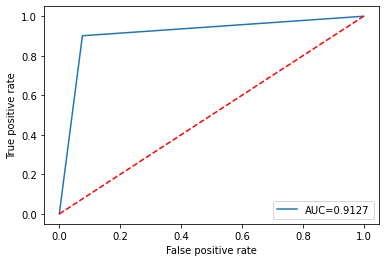

NN test set performance:	AUC=0.9127	Accuracy=0.9128
Confusion matrix:
[[584  48]
 [ 61 557]]


In [20]:
# assess sentiment classification model
auc, acc, _ = assess_sentiment_classifier(y_test, predictions, plot_roc=True)

Note: The ROC curve has an angle-shaped elbow (rather than a curved one) because the output of the huggingface transformers sequence classification models is binary (0,1) and not continuous (like the previous models we used).

---

## SA with huggingface pipelines

In [21]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis',
                      model='distilbert-base-uncased-finetuned-sst-2-english',
                      tokenizer='distilbert-base-uncased')

https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp72ot5nyf


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/4e60bb8efad3d4b7dc9969bf204947c185166a0a3cf37ddb6f481a876a3777b5.9f8326d0b7697c7fd57366cdde57032f46bc10e37ae81cb7eb564d66d23ec96b
creating metadata file for /root/.cache/huggingface/transformers/4e60bb8efad3d4b7dc9969bf204947c185166a0a3cf37ddb6f481a876a3777b5.9f8326d0b7697c7fd57366cdde57032f46bc10e37ae81cb7eb564d66d23ec96b
loading configuration file https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/4e60bb8efad3d4b7dc9969bf204947c185166a0a3cf37ddb6f481a876a3777b5.9f8326d0b7697c7fd57366cdde57032f46bc10e37ae81cb7eb564d66d23ec96b
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-sst-2-english",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout":

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/8d04c767d9d4c14d929ce7ad8e067b80c74dbdb212ef4c3fb743db4ee109fae0.9d268a35da669ead745c44d369dc9948b408da5010c6bac414414a7e33d5748c
creating metadata file for /root/.cache/huggingface/transformers/8d04c767d9d4c14d929ce7ad8e067b80c74dbdb212ef4c3fb743db4ee109fae0.9d268a35da669ead745c44d369dc9948b408da5010c6bac414414a7e33d5748c
loading weights file https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/8d04c767d9d4c14d929ce7ad8e067b80c74dbdb212ef4c3fb743db4ee109fae0.9d268a35da669ead745c44d369dc9948b408da5010c6bac414414a7e33d5748c
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-bas

In [22]:
classifier('I love this book')[0]['label']

'POSITIVE'

In [27]:
tmp = classifier('I love this book')
tmp

[{'label': 'POSITIVE', 'score': 0.9998767375946045}]

In [23]:
def classify(data):
    classifications = []
    for row in data:
          row = ' '.join(row.split()[:280]) # truncate inputs to 280 words
          classifications.append(classifier(row)[0]['label'])
    return classifications

In [24]:
predictions = classify(X_test)

In [25]:
predictions = [int(u in 'POSITIVE') for u in predictions]

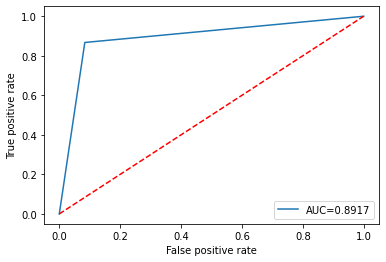

NN test set performance:	AUC=0.8917	Accuracy=0.8920
Confusion matrix:
[[579  53]
 [ 82 536]]


In [26]:
auc, acc, _ = assess_sentiment_classifier(y_test, predictions, plot_roc=True)